In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the Lorenz system equations
def lorenz(x, y, z, sigma=10, rho=28, beta=8/3):
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return dx_dt, dy_dt, dz_dt

In [19]:
# Runge-Kutta integration method to solve the Lorenz system with noise. The method adds a midpoint between discrete points so more training data
def runge_kutta_lorenz_with_noise(x0, y0, z0, sigma=10, rho=28, beta=8/3, dt=0.01, timesteps=10000, noise_std=0.1):
    x_traj, y_traj, z_traj = [x0], [y0], [z0]
    for _ in range(timesteps):
        # Calculate derivatives using the Lorenz equations
        dx1, dy1, dz1 = lorenz(x_traj[-1], y_traj[-1], z_traj[-1], sigma, rho, beta)
        dx2, dy2, dz2 = lorenz(x_traj[-1] + 0.5 * dt * dx1, y_traj[-1] + 0.5 * dt * dy1, z_traj[-1] + 0.5 * dt * dz1, sigma, rho, beta)
        dx3, dy3, dz3 = lorenz(x_traj[-1] + 0.5 * dt * dx2, y_traj[-1] + 0.5 * dt * dy2, z_traj[-1] + 0.5 * dt * dz2, sigma, rho, beta)
        dx4, dy4, dz4 = lorenz(x_traj[-1] + dt * dx3, y_traj[-1] + dt * dy3, z_traj[-1] + dt * dz3, sigma, rho, beta)
        
        # Add noise to the trajectory --> more realisitc, especially observational data
        noise_x = np.random.normal(0, noise_std)
        noise_y = np.random.normal(0, noise_std)
        noise_z = np.random.normal(0, noise_std)
        
        # Update trajectory using Runge-Kutta method
        x_traj.append(x_traj[-1] + (dt / 6) * (dx1 + 2*dx2 + 2*dx3 + dx4) + noise_x)
        y_traj.append(y_traj[-1] + (dt / 6) * (dy1 + 2*dy2 + 2*dy3 + dy4) + noise_y)
        z_traj.append(z_traj[-1] + (dt / 6) * (dz1 + 2*dz2 + 2*dz3 + dz4) + noise_z)
        
    return np.array(x_traj), np.array(y_traj), np.array(z_traj)

In [4]:
# Generate training data using Runge-Kutta with noise
x0, y0, z0 = 1.0, 1.0, 1.0
x_train, y_train, z_train = runge_kutta_lorenz_with_noise(x0, y0, z0)

# Convert training data to torch tensors
x_phys = torch.tensor(np.column_stack((x_train, y_train, z_train)), dtype=torch.float32)
print(f"x_phys {x_phys.shape}") # [num of points/time steps, 3] --> ideal input for pytorch, make sense when doing matrix multiplication

In [5]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 50) # Input is (3,) to create [num of points, 50]
        self.fc2 = nn.Linear(50, 50) # Then becomes [num of points, 50]
        self.fc3 = nn.Linear(50, 3) # Output is [num of points, 3]

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return xn

In [11]:
# Define the loss function
def loss_fn(model, x_phys):
    inputs = x_phys.clone().detach().requires_grad_(True) # detach() separates x from the computational graph of x_phys
    x_pred = model(inputs)
    dx_dt_pred, dy_dt_pred, dz_dt_pred = torch.chunk(x_pred, 3, dim=1) # Converts tensor into three chunks along the columns
    x, y, z = torch.chunk(inputs, 3, dim=1)
    dx_dt, dy_dt, dz_dt = lorenz(x, y, z)
    loss_eqn = torch.mean((dx_dt_pred - dx_dt)**2 + (dy_dt_pred - dy_dt)**2 + (dz_dt_pred - dz_dt)**2) # Should be a scalar value
    return loss_eqn

In [17]:
# Training function
def train(model, optimizer, num_epochs=15000):
    for epoch in range(num_epochs):
        optimizer.zero_grad() # Every epoch, reset calculations
        loss = loss_fn(model, x_phys)
        loss.backward() # Calculate the gradient of the loss 
        optimizer.step() # Updates weights
        if epoch == 1 or epoch % 100 == 0 and epoch != 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')

In [18]:
# Initialize model and optimizer
model = PINN()
optimizer = optim.AdamW(model.parameters(), lr=0.0008)

# Train the model
train(model, optimizer)

Epoch [1/15000], Loss: 12494.0166015625
Epoch [100/15000], Loss: 11723.11328125
Epoch [200/15000], Loss: 10712.8701171875
Epoch [300/15000], Loss: 9679.84765625
Epoch [400/15000], Loss: 8882.720703125
Epoch [500/15000], Loss: 8271.5673828125
Epoch [600/15000], Loss: 7759.0283203125
Epoch [700/15000], Loss: 7316.58251953125
Epoch [800/15000], Loss: 6922.28955078125
Epoch [900/15000], Loss: 6566.767578125
Epoch [1000/15000], Loss: 6243.2265625
Epoch [1100/15000], Loss: 5946.29052734375
Epoch [1200/15000], Loss: 5672.041015625
Epoch [1300/15000], Loss: 5416.779296875
Epoch [1400/15000], Loss: 5175.9677734375
Epoch [1500/15000], Loss: 4949.142578125
Epoch [1600/15000], Loss: 4735.044921875
Epoch [1700/15000], Loss: 4532.10400390625
Epoch [1800/15000], Loss: 4339.66259765625
Epoch [1900/15000], Loss: 4157.017578125
Epoch [2000/15000], Loss: 3983.323974609375
Epoch [2100/15000], Loss: 3817.6103515625
Epoch [2200/15000], Loss: 3659.17529296875
Epoch [2300/15000], Loss: 3507.647216796875
Epoch

Epoch [1/15000], Loss: 11048.71875
Epoch [101/15000], Loss: 10358.85546875
Epoch [201/15000], Loss: 9369.7998046875
Epoch [301/15000], Loss: 8481.3564453125
Epoch [401/15000], Loss: 7793.703125
Epoch [501/15000], Loss: 7248.0673828125
Epoch [601/15000], Loss: 6788.86767578125
Epoch [701/15000], Loss: 6390.0400390625
Epoch [801/15000], Loss: 6037.9072265625
Epoch [901/15000], Loss: 5721.6884765625
Epoch [1001/15000], Loss: 5433.93603515625
Epoch [1101/15000], Loss: 5170.47021484375
Epoch [1201/15000], Loss: 4928.6181640625
Epoch [1301/15000], Loss: 4704.99658203125
Epoch [1401/15000], Loss: 4494.5517578125
Epoch [1501/15000], Loss: 4295.48388671875
Epoch [1601/15000], Loss: 4109.15087890625
Epoch [1701/15000], Loss: 3933.80712890625
Epoch [1801/15000], Loss: 3768.26806640625
Epoch [1901/15000], Loss: 3611.637939453125
Epoch [2001/15000], Loss: 3463.222412109375
Epoch [2101/15000], Loss: 3322.12158203125
Epoch [2201/15000], Loss: 3187.3603515625
Epoch [2301/15000], Loss: 3058.64038085937

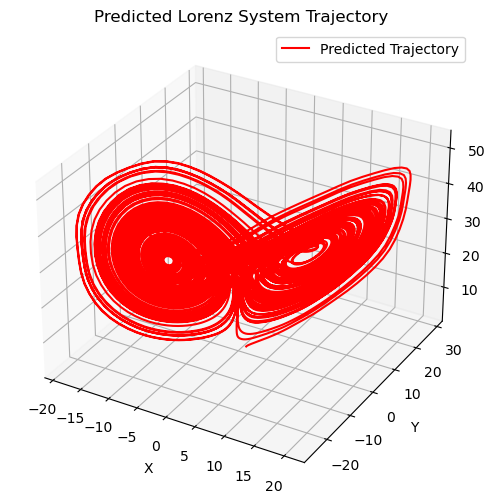

In [67]:
# Function to simulate the Lorenz system using Euler integration
def simulate_lorenz(x0, y0, z0, model, t_span, dt):
    timesteps = int((t_span[1] - t_span[0]) / dt)
    x, y, z = [x0], [y0], [z0]
    for _ in range(timesteps):
        with torch.no_grad():
            x_phys = torch.tensor([[x[-1], y[-1], z[-1]]], dtype=torch.float32)
            dx_dt_pred, dy_dt_pred, dz_dt_pred = torch.chunk(model(x_phys), 3, dim=1)
        dx = dx_dt_pred.item() * dt
        dy = dy_dt_pred.item() * dt
        dz = dz_dt_pred.item() * dt
        x.append(x[-1] + dx)
        y.append(y[-1] + dy)
        z.append(z[-1] + dz)
    return np.array(x), np.array(y), np.array(z)

In [72]:
# !pip install --upgrade pip
# !pip install --upgrade "jax[cpu]"
# Define the initial conditions and time span for prediction
x0, y0, z0 = x_train[0], y_train[0], z_train[0]
t_span = (0, 130)  # Time span for prediction
dt = 0.01  # Time step for numerical integration

# Predict the trajectory using the trained model
x_pred, y_pred, z_pred = simulate_lorenz(x0, y0, z0, model, t_span, dt)

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot predicted trajectory
ax.plot(x_pred, y_pred, z_pred, label='Predicted Trajectory', color='red', linestyle='-')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Predicted Lorenz System Trajectory')
ax.legend()
plt.show()

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [ ]:
# !pip install --upgrade pip
# !pip install --upgrade "jax[cpu]"